Secondary Model
- inputs
    - labels: meta-label(outcome of primary model = trading strategy)
    - features: same as momentum classifiers

- models: SVM, Random Forest, Gradient Boosting, LSTM

- outputs
    - bet confidence

- strategy enhancing


In [1]:
# lib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns;sns.set()
plt.style.use('tableau-colorblind10')

# different models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score

# homemade
from feature_engineering import dimension_reduction as DR
from features import tautil
from labeling import labeling
from backtest import round_trip
from triple_barrier import make_rt

from mlutil.pkfold import PKFold

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

# get X,y

In [3]:
market_df = pd.read_csv('C:data/market_samsung.csv')
market_df = market_df.rename(columns={market_df.columns[0]:'Date'})
market_df.index = pd.to_datetime(market_df.Date)
market_df.drop(columns='Date',inplace=True)
market_df.dropna(inplace=True)
close = market_df.close['2010':'2020']

feature_df = pd.read_csv('C:data/features_samsung.csv')
feature_df = feature_df.rename(columns={feature_df.columns[0]:'Date'})
feature_df.index = pd.to_datetime(feature_df.Date)
feature_df.drop(columns='Date',inplace=True)
feature_df.dropna(inplace=True)

selected_features = pd.read_csv('C:data/selected_features.csv').columns[1:]

In [4]:
feature = feature_df.dropna()
feature = feature[selected_features]
sc = StandardScaler()
X_sc = sc.fit_transform(feature)
X_sc = pd.DataFrame(X_sc, index=feature.index, columns=feature.columns)

In [5]:
#benchmark
barrier_bm = pd.read_csv('C:data/barrier_bm.csv')
barrier_bm.index = pd.to_datetime(barrier_bm.Date)
barrier_bm.exit = pd.to_datetime(barrier_bm.exit)
barrier_bm.drop(columns='Date',inplace=True)

In [6]:
#labeling
barrier = pd.read_csv('C:data/barrier.csv')
barrier.index = pd.to_datetime(barrier.Date)
barrier.exit = pd.to_datetime(barrier.exit)
barrier.drop(columns='Date',inplace=True)

rts = make_rt(close,barrier.dropna())
outcome = rts.rt_returns
outcome.index = rts.open_dt

In [7]:
#meta-label
wl = np.sign(np.sign(outcome)+1)
y_ = wl
y_.value_counts()

1.0    608
0.0    421
Name: rt_returns, dtype: int64

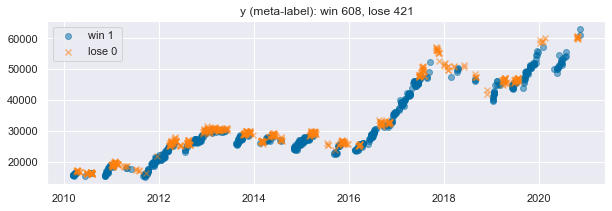

In [10]:
loss = wl.value_counts()[0]
win = wl.value_counts()[1]
plt.figure(figsize=(10,3))
plt.scatter(wl[wl==1].index,close.loc[wl[wl==1].index], alpha=0.5)
plt.scatter(wl[wl==0].index,close.loc[wl[wl==0].index], marker='x', alpha=0.5)
plt.legend(['win 1','lose 0'])
plt.title('y (meta-label): win {}, lose {}'.format(win,loss))
plt.show()

In [9]:
raw_X = X_sc.copy()
tmp = raw_X.join(y_).dropna()
X=tmp.iloc[:,:-1]
y=tmp.iloc[:,-1]

# Model Construction

In [10]:
# Choose model

# Cross Validation (k-fold)
n_cv=4
t1 = pd.to_datetime(barrier.exit.loc[X.index])
cv = PKFold(n_cv,t1,0)

In [11]:
# Choose model (SVM-rbf)
C = [0.1, 1,10]
param_grid_rbf = dict(C=C)
svc_rbf = SVC(kernel='rbf', probability=True)
gs_svc_rbf = GridSearchCV(estimator=svc_rbf, param_grid= param_grid_rbf, cv=cv, scoring='precision')
gs_svc_rbf.fit(X,y)
svc_best = gs_svc_rbf.best_estimator_
svc_best

SVC(C=10, probability=True)

In [12]:
n_estimators = [200,1000]
#max_depth = [3,7]
param_grid_rfc = dict(n_estimators=n_estimators)
rfc = RandomForestClassifier()
gs_rfc = GridSearchCV(estimator=rfc, param_grid= param_grid_rfc, cv=cv, scoring='precision')
gs_rfc.fit(X,y)
rfc_best = gs_rfc.best_estimator_
rfc_best

RandomForestClassifier(n_estimators=200)

In [13]:
n_estimators_ab = [50,100]
learning_rate = [1,0.1]
param_grid_abc = dict(n_estimators=n_estimators_ab, learning_rate=learning_rate)

abc=AdaBoostClassifier()
gs_abc = GridSearchCV(estimator=abc, param_grid= param_grid_abc, cv=cv, scoring='precision')
gs_abc.fit(X,y)
ada_best = gs_abc.best_estimator_
ada_best

AdaBoostClassifier(learning_rate=1, n_estimators=100)

In [14]:
n_estimators_gb = [100,200]
learning_rate = [0.1,0.01]
param_grid_gbc = dict(n_estimators=n_estimators_gb, learning_rate=learning_rate)
gbc=GradientBoostingClassifier()
gs_gbc = GridSearchCV(estimator=gbc, param_grid= param_grid_gbc, cv=cv, scoring='precision')
gs_gbc.fit(X,y)
gbc_best = gs_gbc.best_estimator_
gbc_best

GradientBoostingClassifier(learning_rate=0.01, n_estimators=200)

# Model

In [15]:
clf_list = [svc_best, rfc_best, ada_best, gbc_best]
estimators=['SVM_best','RF_best','AdaBoost_best','GradientBoost_best']
scores_list = []
y_preds_list = []
y_probs_list = []

# for ML model prediction
for clf in clf_list:
    y_preds_ = []
    y_probs_ = []

    for train, test in cv.split(X, y):
        clf.fit(X.iloc[train], y.iloc[train])
        y_true = y.iloc[test]
        y_pred = clf.predict(X.iloc[test])
        y_probs = clf.predict_proba(X.iloc[test])
        y_probs = y_probs[:, 1]
        y_pred_series = pd.Series(y_pred,index=y[test].index)
        y_probs_series = pd.Series(y_probs,index=y[test].index)
        y_preds_.append(y_pred_series)
        y_probs_.append(y_probs_series)
    
    
    y_preds__ = pd.concat([i for i in y_preds_])
    y_probs__ = pd.concat([i for i in y_probs_])
    y_true__ = y.loc[y_preds__.index]
    accs = accuracy_score(y_true__, y_preds__)
    f1=f1_score(y_true__, y_preds__)
    roc=roc_auc_score(y_true__, y_probs__)
    prec=precision_score(y_true__, y_preds__)
    score = [accs, f1, roc, prec]
    scores_list.append(score)
    y_preds_list.append(y_preds__)
    y_probs_list.append(y_probs__)

In [16]:
results = pd.DataFrame(scores_list, columns=['accuracy','f1 score','roc auc score','precision score'],index=estimators)
result_show = results.sort_values('precision score', ascending=False)

In [17]:
result_show

,accuracy,f1 score,roc auc score,precision score
AdaBoost_best,0.567541,0.631927,0.552471,0.635607
SVM_best,0.544218,0.585323,0.574228,0.632887
RF_best,0.549077,0.657817,0.537073,0.596257
GradientBoost_best,0.519922,0.609177,0.490364,0.586890


In [18]:
y_probs_df = pd.DataFrame()
for i in range(len(estimators)):
    y_probs_df[estimators[i]] = y_probs_list[i]

In [19]:
#평균
pred_prob = pd.Series(y_probs_df.mean(axis=1),index=y_probs_df.index)

#하나하나

#y_probs_df_2 = y_probs_df[estimators[3]]
#pred_prob = pd.Series(y_probs_df_2,index=y_probs_df_2.index)

In [20]:
pred_prob2=pd.Series(normalize(pred_prob.to_frame().T).reshape(-1,), index=y_probs_df.index).rename('bet_confidence')

In [21]:
bet_confidence=pd.Series(MinMaxScaler().fit_transform(pred_prob2.to_frame()).reshape(-1,), index=y_probs_df.index).rename('bet_confidence')

Text(0, 0.5, 'counts')

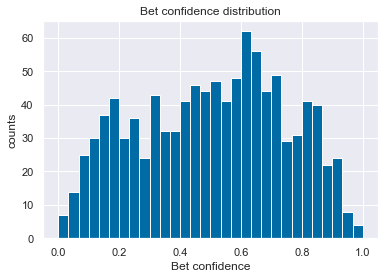

In [41]:
plt.title('Bet confidence distribution')
plt.hist(bet_confidence, bins=30)[2]
plt.xlabel('Bet confidence')
plt.ylabel('counts')

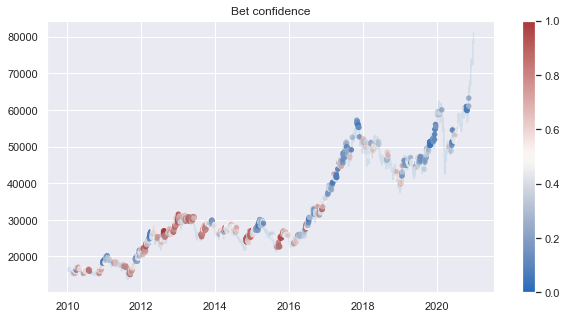

In [45]:
c = close.loc[bet_confidence.index]
plt.figure(figsize=(10,5))
plt.title('Bet confidence')
plt.plot(close, alpha=0.1)
plt.scatter(c.index,c, c = bet_confidence, s=20,cmap='vlag',vmin=0,vmax=1)
plt.colorbar()
plt.show()

# Algo Trading Backtest

In [24]:
barrier_bm = barrier_bm.dropna()
barrier_before = barrier.loc[bet_confidence.index].dropna()
barrier_enhanced = barrier_before.loc[bet_confidence.loc[bet_confidence>0.5].index]

In [25]:
rts_bm = make_rt(close,barrier_bm)
rts_before = make_rt(close,barrier_before)
rts_enhanced = make_rt(close,barrier_enhanced)

In [26]:
result1 = pd.concat([round_trip.get_df_ann_sr(rts_bm,'Benchmark',years=11),
                    round_trip.get_df_ann_sr(rts_before,'Trading Strategy (Primary)',years=11)],axis=1)

df_sr = round_trip.get_df_ann_sr(rts_enhanced,'Enhanced Trading Strategy (Second)',years=11)
result1 = result1.join(df_sr)

In [27]:
result1

,Benchmark,Trading Strategy (Primary),Enhanced Trading Strategy (Second)
avg_n_bets_per_year,246.272727,93.545455,49.636364
win_ratio,0.520506,0.590467,0.612844
annualized_sharpe_ratio,0.538232,1.525995,1.623284


In [33]:
result2 = pd.concat([round_trip.get_df_ann_sr(rts_bm,'Benchmark',years=11),
                    round_trip.get_df_ann_sr(rts_before,'Trading Strategy (Primary)',years=11)],axis=1)
winr = []
for i in np.linspace(0.1,0.9,9):
    barrier_enhanced_ = barrier_before.loc[bet_confidence.loc[bet_confidence>=i].index]
    rts_enhanced_ = make_rt(close,barrier_enhanced_)
    df_sr = round_trip.get_df_ann_sr(rts_enhanced_,'b',years=11)
    winr.append(df_sr.T.win_ratio[0])

In [34]:
dict_ = dict(zip(np.linspace(0.1,0.9,9).round(2),winr))

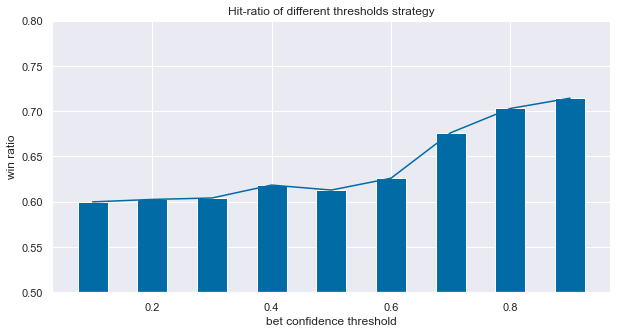

In [49]:
df_res = pd.DataFrame.from_dict(dict_,orient='index')
plt.figure(figsize=(10,5))
plt.title("Hit-ratio of different thresholds strategy")
plt.bar(df_res.index, df_res[0], width=0.05)
plt.plot(df_res)
plt.ylabel('win ratio')
plt.xlabel('bet confidence threshold')
plt.ylim(0.5,0.8)
plt.show()